## 라이브러리 임포트 

In [1]:
## library import - data preprocessing
import pandas as pd
import numpy as np
import os

In [2]:
## BERT embedding 
from transformers import BertTokenizer, BertModel
import torch 

In [3]:
## Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [4]:
## 평가 지표 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

In [5]:
## visualization
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [6]:
import matplotlib.font_manager as fm

# 한글 폰트 설정 (윈도우용)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

In [7]:
# tqdm 
from tqdm import tqdm 

In [8]:
# kaggle hub
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [9]:
## GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 중인 디바이스:", device)

사용 중인 디바이스: cuda


In [10]:
print("CUDA 사용 가능?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("사용 중인 GPU:", torch.cuda.get_device_name(0))
else:
    print("GPU를 사용할 수 없습니다.")


CUDA 사용 가능? True
사용 중인 GPU: NVIDIA GeForce MX450


## data load

In [11]:
pip install kagglehub[pandas-datasets]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# Download latest version
path = kagglehub.dataset_download("datasnaek/youtube-new")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\wonny\.cache\kagglehub\datasets\datasnaek\youtube-new\versions\115


In [13]:
# load USvideo Dataset
df = pd.read_csv(os.path.join(path, "USvideos.csv"))

In [14]:
# data 확인
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [15]:
# 데이터 확인 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

## data preprocessing

### null/duplicate check

In [16]:
df.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

In [17]:
# 중복 확인 
df.duplicated().sum()

48

In [18]:
# 중복된 행 확인 
df[df.duplicated()]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
34899,QBL8IRJ5yHU,18.15.05,Why I'm So Scared (being myself and crying too...,grav3yardgirl,26,2018-05-14T19:00:01.000Z,"beauty|""how to""|""makeup""|""howto""|""style""|""fash...",1469627,188652,3124,33032,https://i.ytimg.com/vi/QBL8IRJ5yHU/default.jpg,False,False,False,I will never be able to say Thank You enough.....
34900,t4pRQ0jn23Q,18.15.05,YoungBoy Never Broke Again Goes Sneaker Shoppi...,Complex,24,2018-05-14T14:00:03.000Z,"sneakerhead|""complex""|""complex originals""|""sne...",1199587,49709,2380,7261,https://i.ytimg.com/vi/t4pRQ0jn23Q/default.jpg,False,False,False,YoungBoy Never Broke Again goes Sneaker Shoppi...
34901,j4KvrAUjn6c,18.15.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",3906727,77378,12160,15874,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! WANT TO SEE US IN NYC & NJ?!BUY...
34902,MAjY8mCTXWk,18.15.05,"周杰倫 Jay Chou【不愛我就拉倒 If You Don't Love Me, It's...",杰威爾音樂 JVR Music,10,2018-05-14T15:59:47.000Z,"周杰倫|""Jay""|""Chou""|""周董""|""周杰伦""|""周傑倫""|""杰威尔""|""周周""|""...",916128,40485,1042,4746,https://i.ytimg.com/vi/MAjY8mCTXWk/default.jpg,False,False,False,詞：周杰倫、宋健彰（彈頭） 曲：周杰倫憂鬱型男的走心旋律 用英式搖滾宣洩情傷不愛我就拉倒...
34903,xhs8tf1v__w,18.15.05,Terry Crews Answers the Web's Most Searched Qu...,WIRED,24,2018-05-14T16:00:29.000Z,"autocomplete|""deadpool 2""|""google autocomplete...",343967,16988,132,1308,https://i.ytimg.com/vi/xhs8tf1v__w/default.jpg,False,False,False,Terry Crews takes the WIRED Autocomplete Inter...
34904,E21NATEP9QI,18.15.05,Why Stradivarius violins are worth millions,Vox,25,2018-05-14T12:00:03.000Z,"vox.com|""vox""|""explain""|""stradivarius""|""violin...",433833,12356,307,1129,https://i.ytimg.com/vi/E21NATEP9QI/default.jpg,False,False,False,Many musicians prefer these 300-year-old instr...
34905,jzLlsbdrwQk,18.15.05,"$17 Pet vs. $100,000 Pet",BuzzFeedBlue,22,2018-05-13T15:00:57.000Z,"buzzfeed|""worth it""|""cheap vs. expensive""|""ste...",3081033,60379,6857,7796,https://i.ytimg.com/vi/jzLlsbdrwQk/default.jpg,False,False,False,“Who is Lennox and why is he so special?”Credi...
34906,1RZYOeQeIXE,18.15.05,Sarah Paulson Gets Scared During '5 Second Rule',TheEllenShow,24,2018-05-14T13:00:00.000Z,"ellen|""ellen degeneres""|""the ellen show""|""seas...",704786,19880,248,669,https://i.ytimg.com/vi/1RZYOeQeIXE/default.jpg,False,False,False,Sarah Paulson agreed to play a friendly game o...
34907,WF82ABLw8s4,18.15.05,Gabby Barrett Sings I Have Nothing by Whitney ...,American Idol,24,2018-05-14T02:23:01.000Z,"ABC|""americanidol""|""idol""|""american idol""|""rya...",735031,11734,1468,1870,https://i.ytimg.com/vi/WF82ABLw8s4/default.jpg,False,False,False,Gabby Barrett sings I Have Nothing by Whitney ...
34908,r-3iathMo7o,18.15.05,"The ULTIMATE $30,000 Gaming PC Setup",Unbox Therapy,28,2018-05-13T19:00:25.000Z,"gaming setup|""gaming""|""setup""|""fortnite""|""fort...",4700460,103430,8028,13293,https://i.ytimg.com/vi/r-3iathMo7o/default.jpg,False,False,False,"Fortnite, PUBG, Far Cry 5? Which game would yo..."


### category mapping 

In [19]:
## 카테고리 매핑 
# JSON 파일 경로
json_path = os.path.join(path, "US_category_id.json")

# JSON 로드
with open(json_path, 'r', encoding='utf-8') as f:
    category_json = json.load(f)

# 카테고리 매핑 딕셔너리 생성
category_mapping = {
    int(item['id']): item['snippet']['title']
    for item in category_json['items']
}

In [20]:
# 매핑 딕셔너리 확인
print(category_mapping)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


In [21]:
df['category_name'] = df['category_id'].map(category_mapping)

In [22]:
df['category_name']

0          People & Blogs
1           Entertainment
2                  Comedy
3           Entertainment
4           Entertainment
               ...       
40944      Pets & Animals
40945      People & Blogs
40946       Entertainment
40947    Film & Animation
40948              Gaming
Name: category_name, Length: 40949, dtype: object

## data EDA

### 종속 변수의 분포 확인

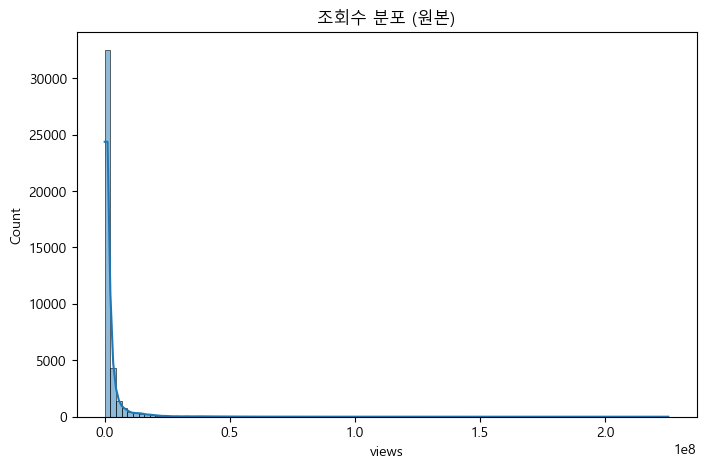

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(df['views'], bins=100, kde=True)
plt.title("조회수 분포 (원본)")
plt.xlabel("views")
plt.show()

In [24]:
# log-scaling 진행
df['log_views'] = np.log1p(df['views'])

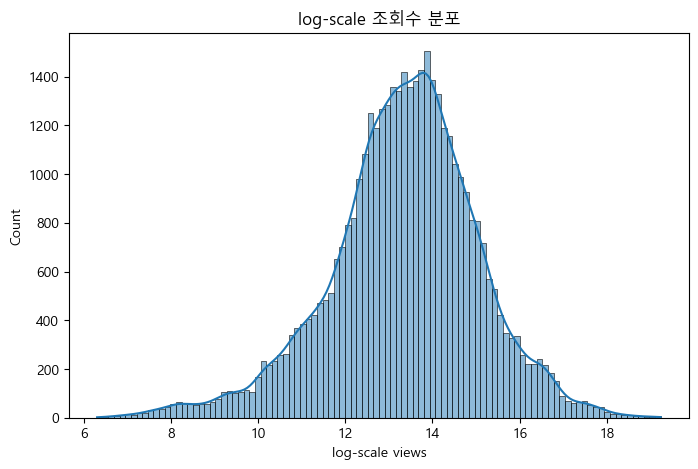

In [25]:
# 변환 후 분포 확인 
plt.figure(figsize=(8, 5))
sns.histplot(df['log_views'], bins=100, kde=True)
plt.title("log-scale 조회수 분포")
plt.xlabel("log-scale views")
plt.show()

### 카테고리별 영상 수 확인 

In [26]:
# 카테고리별 영상 수 확인 
df['category_id'].value_counts()

category_id
24    9964
10    6472
26    4146
23    3457
22    3210
25    2487
28    2401
1     2345
17    2174
27    1656
15     920
20     817
19     402
2      384
29      57
43      57
Name: count, dtype: int64

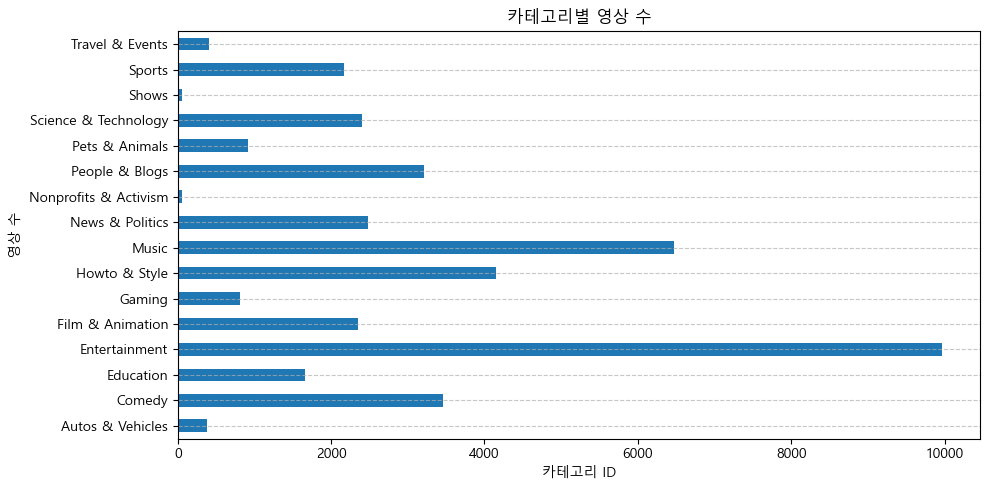

In [27]:
# 카테고리별 영상 수 계산
category_counts = df['category_name'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(10, 5))
category_counts.plot(kind='barh')

plt.title("카테고리별 영상 수")
plt.xlabel("카테고리 ID")
plt.ylabel("영상 수")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 수치형 변수 분포 확인 

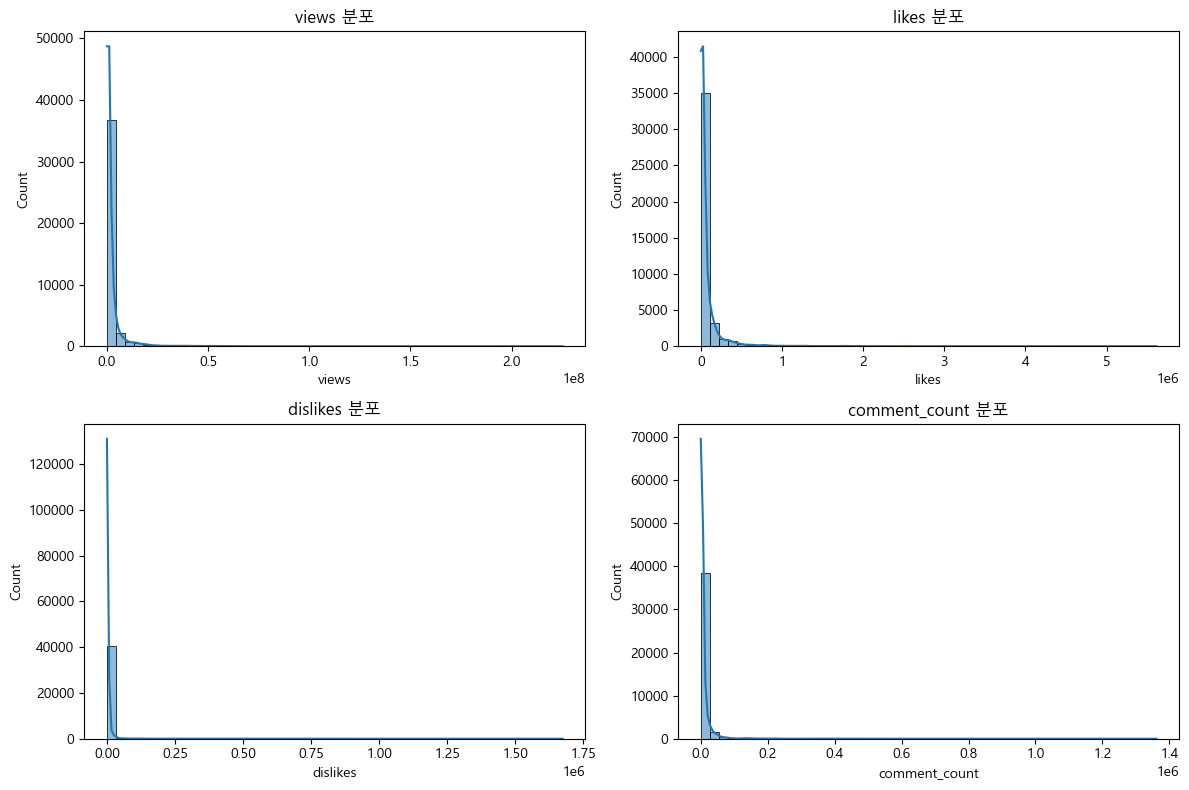

In [28]:
numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"{col} 분포")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [29]:
# 나중에 종속변수로 사용하게 된다면 log-transformation 필요 

## Baseline Model

In [30]:
# 필요한 열만 불러오기 
base_df = df[['title', 'log_views']].dropna()
base_df

,title,log_views
0,WE WANT TO TALK ABOUT OUR MARRIAGE,13.525659
1,The Trump Presidency: Last Week Tonight with J...,14.698775
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",14.975981
3,Nickelback Lyrics: Real or Fake?,12.745978
4,I Dare You: GOING BALD!?,14.555413
...,...,...
40944,The Cat Who Caught the Laser,14.337638
40945,True Facts : Ant Mutualism,13.878297
40946,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,13.879848
40947,How Black Panther Should Have Ended,15.549078


In [31]:
# BERT load 
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [32]:
# BERT embedding extract 

## CLS 벡터 추출 함수 정의 

def extract_cls_embedding(text):
    encoding = tokenizer(text,
                         max_length=32,
                         truncation=True,
                         padding='max_length',
                         return_tensors='pt')
    input_ids_tensor = encoding['input_ids'].to(device)
    attention_mask_tensor = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding


In [33]:
## 전체 제목을 cls로 추출 
embeddings = np.array([
    extract_cls_embedding(title) for title in tqdm(base_df['title'])
])

100%|████████████████████████████████████████████████████████████████████████████| 40949/40949 [18:32<00:00, 36.82it/s]


In [34]:
## X,y 정의 
X = embeddings 
y = base_df['log_views'].values

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = 42)

In [35]:
# 실험할 모델 정의
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [38]:
# 결과 저장
results = []

# 모델별 성능평가
for name, model in tqdm(models.items(), desc="모델별 성능 평가 진행 중"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # MAPE 계산 (0으로 나누는 오류 방지)
    if np.any(y_test == 0):
        mape = np.nan  # 혹은 0이나 다른 처리 방식
    else:
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    spearman_corr, _ = spearmanr(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R²": r2,
        "Spearman": spearman_corr
    })


모델별 성능 평가 진행 중:   0%|                                                                  | 0/5 [00:00<?, ?it/s]C:\Users\wonny\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
모델별 성능 평가 진행 중:  20%|███████████▌                                              | 1/5 [00:01<00:04,  1.14s/it]C:\Users\wonny\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
모델별 성능 평가 진행 중:  40%|███████████████████████▏                                  | 2/5 [00:01<00:01,  1.68it/s]C:\Users\wonny\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarni

In [39]:
# 결과 확인 (스피어만 높은 순)
results_df = pd.DataFrame(results).sort_values(by="Spearman", ascending=False)

print(results_df)

              Model      RMSE       MSE       MAE   MAPE (%)        R²  \
3      RandomForest  0.530299  0.281217  0.307296   2.498073  0.904788   
4  GradientBoosting  1.377054  1.896277  1.054629   8.500939  0.357975   
0  LinearRegression  1.438323  2.068774  1.098163   8.793706  0.299573   
1             Ridge  1.438074  2.068057  1.098036   8.792552  0.299816   
2             Lasso  1.708560  2.919178  1.303460  10.419040  0.011650   

   Spearman  
3  0.957234  
4  0.608201  
0  0.524355  
1  0.524288  
2  0.197207  
